In [223]:
import glob
import os
import shutil
import multiprocessing
import cv2
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_pre
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

## Global

### Variables

In [209]:
dataset_dir = "data/traffic-small"
# dataset_dir = "data/traffic"
dataset = glob.glob(dataset_dir + "/*.jpg")

feature_saved_dir = "extracted_features"

pretrain_input_size = (224, 224)

n_clusters = 14

cpus = multiprocessing.cpu_count()

### Utils

In [3]:
def load_data_as_lines(path):
    r""" Open text file by path and read all lines """
    with open(path, "r") as fh:
        lines = fh.readlines()
        
    # transform docs into lists of words
    raw_lines = [l.split() for l in lines]

    return raw_lines

def save_result_as_file(prediction, file_name="prediction.dat"):
    r""" Save the predicted result as a new file """
    file_content = "\n".join(list(map(str, prediction)))
    with open(file_name, "w") as fd:
        fd.write(file_content) 

## Analytics
Analyze the data distribution first, so we can decide how to resize the image

In [31]:
dim_to_key = lambda dim: "({},{})".format(dim[0], dim[1])

In [32]:
cnt = Counter()

images = []
for path in dataset:
    img = cv2.imread(path)
    key = dim_to_key(img.shape)
    cnt[key] += 1

In [33]:
cnt.most_common()

[('(61,35)', 477),
 ('(61,33)', 349),
 ('(44,24)', 304),
 ('(57,27)', 300),
 ('(65,33)', 295),
 ('(67,32)', 286),
 ('(62,29)', 268),
 ('(57,29)', 263),
 ('(56,33)', 262),
 ('(72,40)', 258),
 ('(62,39)', 257),
 ('(55,32)', 252),
 ('(54,23)', 251),
 ('(49,22)', 234),
 ('(60,36)', 227),
 ('(52,25)', 224),
 ('(52,27)', 220),
 ('(55,26)', 214),
 ('(57,28)', 213),
 ('(46,27)', 211),
 ('(81,42)', 210),
 ('(63,32)', 207),
 ('(53,32)', 205),
 ('(56,24)', 205),
 ('(71,38)', 204),
 ('(70,32)', 200),
 ('(46,24)', 198),
 ('(62,34)', 196),
 ('(59,34)', 195),
 ('(77,146)', 194),
 ('(63,34)', 192),
 ('(72,38)', 190),
 ('(97,38)', 186),
 ('(64,35)', 185),
 ('(59,32)', 185),
 ('(59,26)', 185),
 ('(53,24)', 184),
 ('(63,28)', 183),
 ('(54,24)', 181),
 ('(54,26)', 178),
 ('(47,21)', 175),
 ('(57,26)', 175),
 ('(50,24)', 174),
 ('(51,27)', 172),
 ('(99,44)', 171),
 ('(54,33)', 169),
 ('(57,31)', 169),
 ('(59,31)', 168),
 ('(64,33)', 167),
 ('(57,30)', 162),
 ('(48,21)', 162),
 ('(56,30)', 161),
 ('(44,26)'

## Image Preprocess

In [213]:
images = []
for path in dataset:
    img = image.load_img(path, target_size=pretrain_input_size)
    img = image.img_to_array(img)
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, pretrain_input_size)
#     img = img / 255.0  # Normalization
    images.append(img)

In [214]:
train_input = np.array(images)

In [215]:
train_input.shape

(4209, 224, 224, 3)

## Feature Extraction 

In [7]:
def init_feature_saved_dir():
    if not os.path.exists(feature_saved_dir) or \
        len(os.listdir(feature_saved_dir)) == 0:
        try:
            shutil.rmtree(feature_saved_dir)
        except:
            pass

        os.mkdir(feature_saved_dir)

In [217]:
supported_models = ["vgg", "resnet50"]

def save_batch_features(x, model_name="vgg", pooling=None, save=True, filename=None):
    assert(model_name in supported_models)
    
    init_feature_saved_dir()
    input_dim = pretrain_input_size + (3,)
    
    if model_name == "vgg":
        x = vgg16_pre(x)
        model = VGG16(weights='imagenet',
                      include_top=False,
                      pooling=pooling)
        
    elif model_name == "resnet50":
        x = resnet50_pre(x)
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         pooling=pooling)

#     o = x_in = Input(input_dim)
#     o = model(o)
#     o = Flatten()(o)
    
#     m = Model(inputs=x_in, outputs=o)

    y = model.predict(x,
                      workers=cpus-1,
                      use_multiprocessing=True)
    
    print(y.shape)

    if save or filename:
        name = filename if filename \
            else "features-%s%s" % (
                model_name,
                "-%s" % pooling if pooling else ""
            )
        np.save("%s/%s" % (
            feature_saved_dir, 
            name
        ), y)
    
    return y

In [13]:
features_vgg = save_batch_features(train_input)

Instructions for updating:
Colocations handled automatically by placer.
(4209, 2, 2, 512)


In [14]:
features_resnet50 = save_batch_features(train_input, "resnet50")

/Users/daniel/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


(4209, 2, 2, 2048)


In [15]:
features_vgg_avg = save_batch_features(train_input, pooling="avg")

(4209, 512)


In [16]:
features_vgg_max = save_batch_features(train_input, pooling="max")

(4209, 512)


In [17]:
features_resnet50_avg = save_batch_features(train_input, "resnet50", pooling="avg")

(4209, 2048)


In [18]:
features_resnet50_max = save_batch_features(train_input, "resnet50", pooling="max")

(4209, 2048)


In [218]:
features_resnet50 = save_batch_features(train_input, "resnet50", filename="resnet50_224")

/Users/daniel/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


(4209, 7, 7, 2048)


## Preprocess

### Load data (optional)

In [219]:
x = features_resnet50
# x = np.load(os.path.join(feature_saved_dir, "features-vgg.npy"))

In [220]:
x.shape

(4209, 7, 7, 2048)

### Flatten

In [200]:
def flatten(x):
    return np.array([np.ndarray.flatten(img) for img in x])

In [221]:
x_flatten = flatten(x)

In [222]:
x_flatten.shape

(4209, 100352)

### PCA

In [96]:
def get_pca_data(x_train):
    def percvar(v):
        r"""Transform eigen/singular values into percents.
        Return: vector of percents, prefix vector of percents
        """
        # sort values
        s = np.sort(np.abs(v))
        # reverse sorting order
        s = s[::-1]
        # normalize
        s = s/np.sum(s)
        return s, np.cumsum(s)

    def perck(s, p):
        return next(i + 1 for i, v in enumerate(s) if v >= p)

    X_std = StandardScaler().fit_transform(x_train)
    means = np.mean(X_std, axis=0)
    X_sm = X_std - means
    
    U,s,V = np.linalg.svd(X_sm)
    _, pv = percvar(s**2/(X_sm.shape[0]-1))

    percentage_explained = 99
    n_components = perck(pv, percentage_explained * 0.01)
    
    print("Original: %d. After PCA: %d" % (x_train.shape[-1], n_components))

    svd = TruncatedSVD(n_components=n_components)
    svd.fit(x_train)

    return svd.transform(x_train), svd

In [ ]:
x_flatten_, _ = get_pca_data(x_flatten)

## Clustering

In [36]:
y = load_data_as_lines(os.path.join(dataset_dir, "clusters.txt"))
y = np.array(y).flatten()

In [183]:
model = KMeans(n_clusters=n_clusters, n_jobs=cpus-1, random_state=1)

In [224]:
model.fit(x_flatten)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [225]:
prediction = list(map(lambda x: x, model.labels_.tolist())) # starts from 1

In [226]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([160, 151, 272, 644, 140, 229, 723, 128, 364, 553, 127, 334, 128,
        256]))

In [227]:
np.unique(y, return_counts=True)

(array(['1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7',
        '8', '9'], dtype='<U2'),
 array([1286,   12,   11,  470,   42, 1474,  602,  128,   26,   10,   27,
           7,  105,    9]))

In [228]:
normalized_mutual_info_score(y, prediction)

0.008855636363231624

In [207]:
normalized_mutual_info_score(y, prediction)

0.010101325438759107

In [310]:
all(label <= 14 and label >= 1 for label in prediction)

False

In [176]:
model2 = DBSCAN(eps=0.4, min_samples=5, n_jobs=cpus-1)

In [177]:
model2.fit(x_flatten)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=3, p=None)

In [178]:
len(np.unique(model2.labels_))

7

In [172]:
prediction2 = list(map(lambda x: x, model2.labels_.tolist())) # starts from 1

In [173]:
# VGG + DBSCAN(0.5, 5) 0.024794674645757197
normalized_mutual_info_score(y, prediction2)

0.024794674645757197

In [174]:
svd = TruncatedSVD(n_components=2)
x_pca = svd.fit_transform(x_flatten)
# x_pca = svd.fit_transform(flatten(train_input))



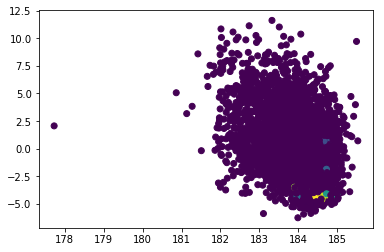

In [175]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=prediction2)
plt.show()

In [219]:
# VGG_MAX
normalized_mutual_info_score(y, prediction)

0.008307981394281364

In [200]:
# VGG_MAX_PCA
normalized_mutual_info_score(y, prediction)

0.009747882300356864

In [208]:
# VGG
normalized_mutual_info_score(y, prediction)

0.009683774163696106

In [212]:
# VGG_PCA
normalized_mutual_info_score(y, prediction)

0.010623286038995799

In [226]:
# RES50
normalized_mutual_info_score(y, prediction)

0.009794626073636827

In [230]:
# RES50_PCA
normalized_mutual_info_score(y, prediction)

0.008068110910338717

In [238]:
# RES50_MAX
normalized_mutual_info_score(y, prediction)

0.01032285854898277

In [243]:
# RES50_MAX_PCA
normalized_mutual_info_score(y, prediction)

0.008569389462865706

In [247]:
xxx = np.array([np.ndarray.flatten(img) for img in train_input])

In [252]:
xxx, _ = get_pca_data(xxx)

Original: 12288. After PCA: 1


In [262]:
model.fit(xxx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [263]:
prediction = list(map(lambda x: x, model.labels_.tolist())) # starts from 1

In [251]:
# RAW input
normalized_mutual_info_score(y, prediction)

0.008940096957797085

In [255]:
# RAW input_PCA
normalized_mutual_info_score(y, prediction)

0.009771149702234222

In [264]:
# RAW input_PCA random1
normalized_mutual_info_score(y, prediction)

0.009972053508513724

In [271]:
# Res50 random1
normalized_mutual_info_score(y, prediction)

0.009137340044138234

In [280]:
clustering = DBSCAN(eps=14, min_samples=4, n_jobs=cpus-1).fit(x_flatten)

In [281]:
np.unique(clustering.labels_)

array([-1,  0,  1])

In [283]:
clustering.components_.shape

(4206, 8192)

In [286]:
np.unique(y, return_counts=True)

(array(['1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7',
        '8', '9'], dtype='<U2'),
 array([1286,   12,   11,  470,   42, 1474,  602,  128,   26,   10,   27,
           7,  105,    9]))

In [311]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([285,   3,  12, 101, 156, 234, 139, 119, 233, 128, 211, 138, 150,
        109, 137, 103, 217, 189, 308, 228, 137, 129, 137, 101, 118,   5,
        220, 162]))

In [312]:
from scipy.spatial import distance_matrix

In [314]:
dists = distance_matrix(model.cluster_centers_, model.cluster_centers_)

In [327]:
mask = np.ones((28,28), dtype=bool)
np.fill_diagonal(mask, 0)
min_value = np.argmin(dists[mask])
print(min_value)

477


In [332]:
centers = model.cluster_centers_

for i in range(1):
    dists = distance_matrix(centers, centers)
    
    for idx, dist in enumerate(dists):
        print(np.min(np.delete(dist, idx)), np.argmin(np.delete(dist, idx)))

0.13544522169086445 26
1080.1188937737816 24
0.5371167124046532 24
0.16695306603724255 8
0.16251038721116073 6
0.1383325167389324 20
0.14325815781358203 9
0.15959871820062146 12
0.13242185098932002 21
0.15652529244382343 10
0.13655964293220305 25
0.15652529244382343 9
0.14798792427202964 17
0.15959871820062146 7
0.13490172280483292 8
0.17306861098722487 18
0.1373982907065224 0
0.1120013122044138 18
0.14798792427202964 12
0.1120013122044138 17
0.1389527036520755 17
0.1383325167389324 5
0.13242185098932002 8
0.18132391958367422 11
0.16449926562900463 21
0.5371167124046532 2
0.13655964293220305 10
0.13544522169086445 0


In [331]:
dists[0][26]

0.3605566300891421

In [20]:
save_result_as_file(prediction, "kmeans_res50_pca.dat")

In [18]:
prediction

[6,
 9,
 5,
 12,
 1,
 13,
 13,
 8,
 8,
 3,
 13,
 5,
 14,
 4,
 2,
 2,
 4,
 2,
 14,
 9,
 4,
 14,
 5,
 3,
 11,
 12,
 10,
 3,
 3,
 7,
 4,
 2,
 4,
 10,
 12,
 11,
 5,
 3,
 10,
 4,
 2,
 14,
 2,
 5,
 9,
 6,
 6,
 12,
 13,
 5,
 1,
 8,
 4,
 9,
 2,
 4,
 13,
 4,
 13,
 5,
 6,
 2,
 1,
 8,
 9,
 3,
 13,
 9,
 9,
 8,
 2,
 12,
 7,
 2,
 1,
 10,
 10,
 4,
 5,
 5,
 1,
 14,
 13,
 2,
 7,
 4,
 4,
 7,
 5,
 3,
 5,
 2,
 7,
 12,
 9,
 13,
 11,
 9,
 5,
 3,
 6,
 4,
 6,
 2,
 14,
 7,
 11,
 2,
 1,
 14,
 4,
 11,
 14,
 12,
 7,
 5,
 1,
 13,
 6,
 13,
 13,
 5,
 2,
 7,
 2,
 4,
 13,
 3,
 7,
 7,
 9,
 9,
 4,
 5,
 9,
 14,
 9,
 9,
 4,
 4,
 2,
 11,
 9,
 12,
 6,
 7,
 3,
 9,
 14,
 1,
 10,
 11,
 5,
 10,
 14,
 7,
 6,
 9,
 13,
 13,
 10,
 6,
 13,
 6,
 14,
 12,
 13,
 7,
 1,
 11,
 9,
 11,
 5,
 7,
 13,
 6,
 7,
 14,
 5,
 7,
 2,
 5,
 12,
 12,
 5,
 11,
 7,
 3,
 11,
 9,
 13,
 14,
 5,
 5,
 5,
 8,
 9,
 5,
 2,
 10,
 8,
 3,
 7,
 5,
 1,
 2,
 8,
 2,
 2,
 3,
 9,
 6,
 7,
 14,
 6,
 4,
 3,
 2,
 8,
 6,
 7,
 6,
 13,
 6,
 2,
 9,
 2,
 13,
 7,
 6,
 3,
 6,
 4,
 

In [180]:
y.tolist()

['3',
 '12',
 '12',
 '12',
 '12',
 '12',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '1',
 '1',
 '2',
 '8',
 '1',
 '2',
 '1',
 '2',
 '1',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '2',
 '14',
 '14',
 '1',
 '1',
 '12',
 '12',
 '12',
 '14',
 '14',
 '14',
 '14',
 '3',
 '14',
 '14',
 '14',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '3',
 '14',
 '14',
 '1',
 '13',
 '13',
 '13',
 '14',
 '14',
 '14',
 '14',
 '2',
 '14',
 '3',
 '1',
 '2',
 '14',
 '1',
 '3',
 '1',
 '1',
 '8',
 '1',
 '2',
 '14',
 '14',
 '14',
 '12',
 '12',
 '14',
 '14',
 '14',
 '12',
 '14',
 '8',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '2',
 '1',
 '1',
 '1',
 '14',
 '1',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '14',
 '14',
 '14',
 '14',
 '12',
 '12',
 '12',
 '14',
 '14',
 '14',
 '14',
 '12',
 '12',
 '12',
 '14',
 '14',
 '14',
 '14',
 '2',
 '14',
 '14',
 '14',
 '14',
 '14',
 '12',
 '12',
 '14',
 '14',
 '4',
 '2',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '14',
 '12',
 